# Türkçe Veri Seti üzerinde nlp projesi çalışması
- veri seti linki : https://github.com/turkish-nlp-suite/BeyazPerde-Movie-Reviews/blob/main/butun-fimler/all_movies_reviews.json

## kütüphaneleri yükleme

In [10]:
import json

import pandas as pd
import numpy as np

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('turkish'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Veri Setini Yükle ve Hazırla

In [ ]:
with open('all_movies_reviews.json','r',encoding='utf-8') as file:  # aynı dizinde olmalı all_movies_reviews.json dosyası main.ipynb ile 
    data=json.load(file)

In [3]:
yorumlar=[]
derecelendirmeler=[]

for film in data:
    for review in film['reviews']:
        yorumlar.append(review['review'])
        derecelendirmeler.append(float(review['rating'].replace(',', '.')))

In [5]:
# DataFrame oluştur
df = pd.DataFrame({'review': yorumlar, 'rating': derecelendirmeler})
df

,review,rating
0,Filmi bugün Nişanlımla birlikte izleme şansım ...,4.0
1,Film gerçekten hakkını veriyor. Saatin nasıl g...,5.0
2,Açıkçası film beklentilerimi karşılayamadı. Ta...,3.5
3,Bu eleştiride spoiler vardır! Avatar the way o...,5.0
4,"SADECE SİNEMA KONUŞULAN, YORUMLAR YAPILAN, TAV...",5.0
...,...,...
45275,"Film konu olarak ilginç, ancak filmde eksik bi...",2.5
45276,Film çok ilginç bir senaryoya sahip. sıradanlı...,4.0
45277,Büyük bir vakit kaybı. Televizyonu açıp rastge...,1.0
45278,Film çok güzel.Mutlaka izleyin.Bide arkadaşlar...,5.0


## Yorumları Sınıflandır

In [7]:
# Puanı 3.5 ve üzeri olanları olumlu (1), altındakileri olumsuz (0) olarak etiketle
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 3.5 else 0)
df

,review,rating,sentiment
0,Filmi bugün Nişanlımla birlikte izleme şansım ...,4.0,1
1,Film gerçekten hakkını veriyor. Saatin nasıl g...,5.0,1
2,Açıkçası film beklentilerimi karşılayamadı. Ta...,3.5,1
3,Bu eleştiride spoiler vardır! Avatar the way o...,5.0,1
4,"SADECE SİNEMA KONUŞULAN, YORUMLAR YAPILAN, TAV...",5.0,1
...,...,...,...
45275,"Film konu olarak ilginç, ancak filmde eksik bi...",2.5,0
45276,Film çok ilginç bir senaryoya sahip. sıradanlı...,4.0,1
45277,Büyük bir vakit kaybı. Televizyonu açıp rastge...,1.0,0
45278,Film çok güzel.Mutlaka izleyin.Bide arkadaşlar...,5.0,1


## Veriyi Keşfet

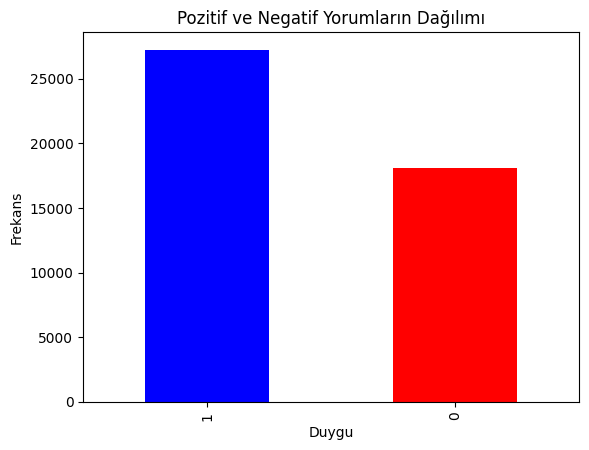

In [9]:
import matplotlib.pyplot as plt
df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title("Pozitif ve Negatif Yorumların Dağılımı")
plt.xlabel("Duygu")
plt.ylabel("Frekans")
plt.show()


## Veriyi Temizle

In [17]:
def metni_temizle(text):
    text = text.lower()  # Küçük harfe çevir
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldır
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Stopwords temizle
    return " ".join(words)

df['cleaned_review'] = df['review'].apply(metni_temizle)


## Metinleri Sayısallaştır (tokenization)

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)  # En sık kullanılan 5000 kelimeyi kullan
X = vectorizer.fit_transform(df['cleaned_review']).toarray()

## Veriyi Eğitim ve Test Setine Ayır (train-test-split)

In [13]:
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Modeli Seç ve Eğit 

In [14]:
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

## Modeli Değerlendir

In [16]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluk Oranı: {accuracy:.2f}\n")

print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

print("\nKarışıklık Matrisi:")
print(confusion_matrix(y_test, y_pred))


Model Doğruluk Oranı: 0.79

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.83      0.60      0.70      3611
           1       0.78      0.92      0.84      5445

    accuracy                           0.79      9056
   macro avg       0.80      0.76      0.77      9056
weighted avg       0.80      0.79      0.78      9056


Karışıklık Matrisi:
[[2172 1439]
 [ 446 4999]]


## Gerçek Yorumlarla Test Et

In [ ]:
new_review_p = ["Bu film gerçekten harikaydı, oyunculuk mükemmeldi!"]
new_review_p_cleaned = [metni_temizle(new_review_p[0])]
new_review_p_tfidf = vectorizer.transform(new_review_p_cleaned).toarray()

prediction = model.predict(new_review_p_tfidf)
sentiment_label = "Olumlu" if prediction[0] == 1 else "Olumsuz"
print(f"Yorumun Tahmin Edilen Duygusu: {sentiment_label}")


Yorumun Tahmin Edilen Duygusu: Olumlu


In [19]:
new_review_n = ["Bu film berbattı , oyuncu kadrosunun genişliğine aldanıp açtım kimseye önermem!!!"]
new_review_n_cleaned = [metni_temizle(new_review_n[0])]
new_review_n_tfidf = vectorizer.transform(new_review_n_cleaned).toarray()

prediction = model.predict(new_review_n_tfidf)
sentiment_label = "Olumlu" if prediction[0] == 1 else "Olumsuz"
print(f"Yorumun Tahmin Edilen Duygusu: {sentiment_label}")

Yorumun Tahmin Edilen Duygusu: Olumsuz
